In [ ]:
!git clone https://github.com/ch2343/scCRAFT.git

In [ ]:
%cd scCRAFT
!pip install .

In [ ]:
!pip install harmonypy

In [1]:
import scanpy as sc
import numpy as np
import scCRAFT
from scCRAFT.model import *
import harmonypy as hm
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import scib
import louvain
import seaborn as sns
import torch
import scanorama

/Users/sheena/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/sheena/Library/Python/3.9/lib/python/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


In [4]:
import anndata
adata = anndata.read_h5ad("../bct_raw.h5ad")

adata.obs.rename(columns={'BATCH': 'batch', 'celltype': 'cell_type'}, inplace=True)
adata

AnnData object with n_obs × n_vars = 9288 × 1222
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'study', 'cell.class', 'library_size', 'detected_genes', 'batch', 'cell_type'
    var: 'gene.symbols', 'gene.counts'

There are three cell types and three batches in this datasets

In [5]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
embeddings_dict = {}

# Scanorama

In [7]:
import anndata as ad

def split_batches(adata, batch_key, return_categories=False):
    """
    Split an AnnData object into a list of AnnData objects by batch.
    
    Parameters:
    - adata (AnnData): The AnnData object to split.
    - batch_key (str): The key in `adata.obs` used to identify batches.
    - return_categories (bool): Whether to return the unique categories (batch labels).

    Returns:
    - list: A list of AnnData objects, one for each batch.
    - list (optional): A list of unique batch categories, if `return_categories` is True.
    """
    if batch_key not in adata.obs:
        raise ValueError(f"Batch key '{batch_key}' not found in adata.obs.")
    
    categories = adata.obs[batch_key].unique().tolist()
    split_data = [adata[adata.obs[batch_key] == batch].copy() for batch in categories]
    
    if return_categories:
        return split_data, categories
    return split_data

In [10]:
#Scanorama
# Save original order of cells
original_order = adata.obs_names.copy()

# Your existing Scanorama correction process
split, categories = split_batches(adata.copy(), 'batch', return_categories=True)
corrected = scanorama.correct_scanpy(split, return_dimred=True)
corrected = anndata.AnnData.concatenate(
    *corrected, batch_key='batch', batch_categories=categories, index_unique=None
)

# Reorder corrected data to match original order
corrected = corrected[original_order]

# Replace adata with corrected data
adatas = corrected.copy()

Found 1222 genes among all datasets
[[0.         0.6099675  0.0595883 ]
 [0.         0.         0.65491803]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)


In [11]:
adata.obsm['X_scanorama'] = adatas.obsm['X_scanorama']

embeddings_dict['X_scanorama'] = adata.obsm["X_scanorama"]

In [12]:
embeddings_dict.keys()

dict_keys(['X_scVI', 'X_harmony', 'X_scCRAFT', 'X_seurat', 'X_scanorama'])

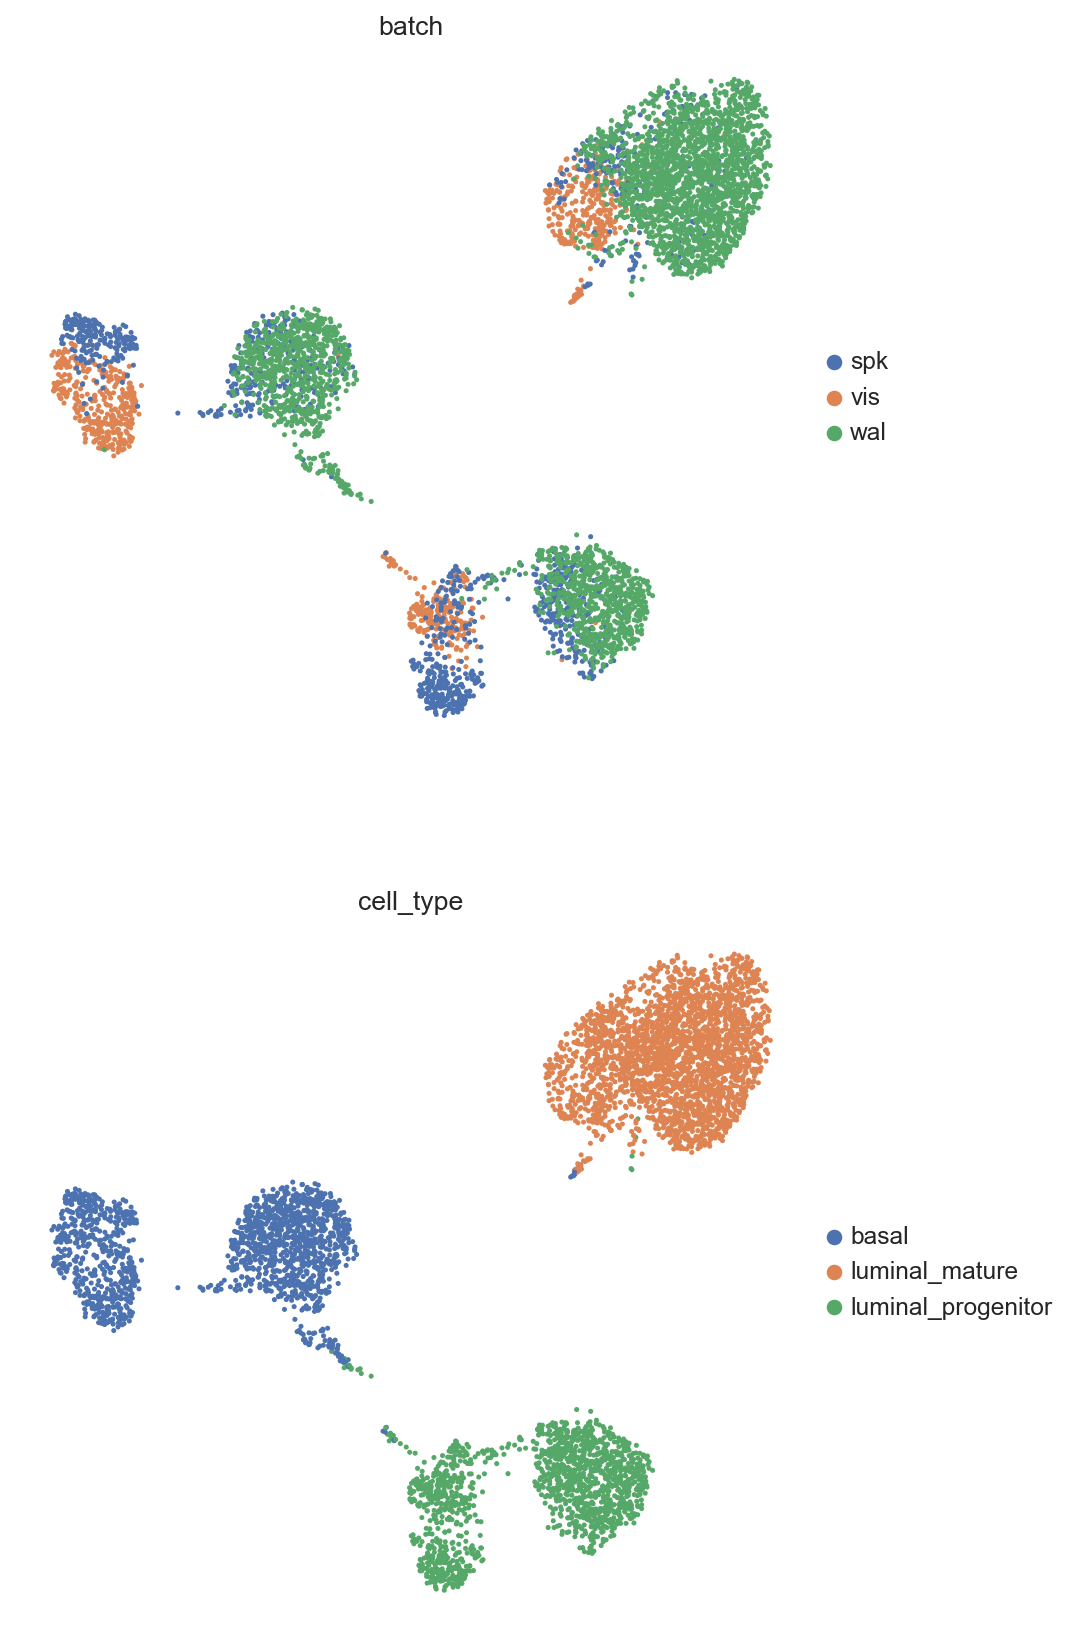

In [13]:
# Umap Plotting
sc.pp.neighbors(adata, n_pcs=30, use_rep="X_scanorama")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# scCRAFT

In [5]:
# scCRAFT
multi_resolution_cluster(adata, resolution1 = 1, method = 'Leiden')
VAE = train_integration_model(adata, batch_key = 'batch', z_dim=256, d_coef = 0.2)
obtain_embeddings(adata, VAE)
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
sc.tl.umap(adata, min_dist=0.5)

150


Overall Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training completed in 54.09 seconds


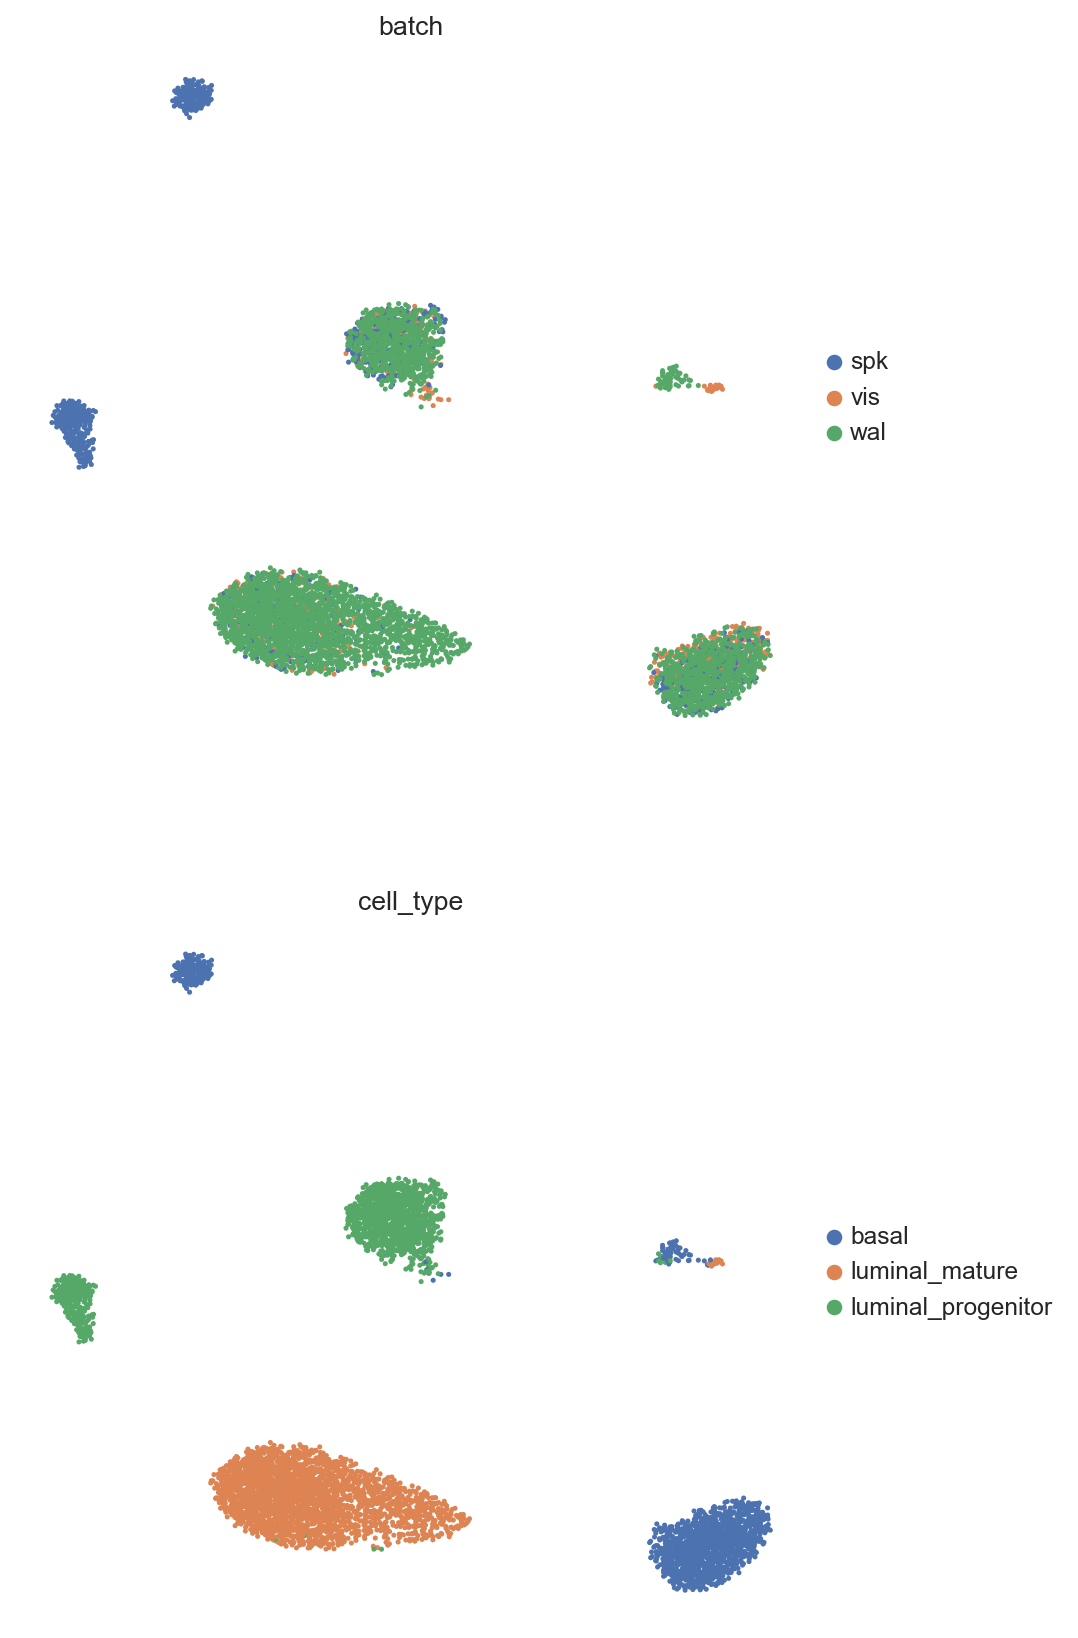

In [6]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [7]:
# Save embeddings
adata.obsm["X_scCRAFT"] = adata.obsm["X_scCRAFT"]

# Collect embeddings
embeddings_dict = {"X_scCRAFT": adata.obsm["X_scCRAFT"]}

# scVI

In [8]:
# scVI
adata = adata.copy()
adata.layers['counts'] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█| 400/400 [02:24<00:00,  4.46it/s, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [02:24<00:00,  2.77it/s, v_num=1, train_loss_step


In [9]:
# Assuming 'vae' is your trained model
model_path = "./model_scVI"
vae.save(model_path, overwrite=True)

In [10]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

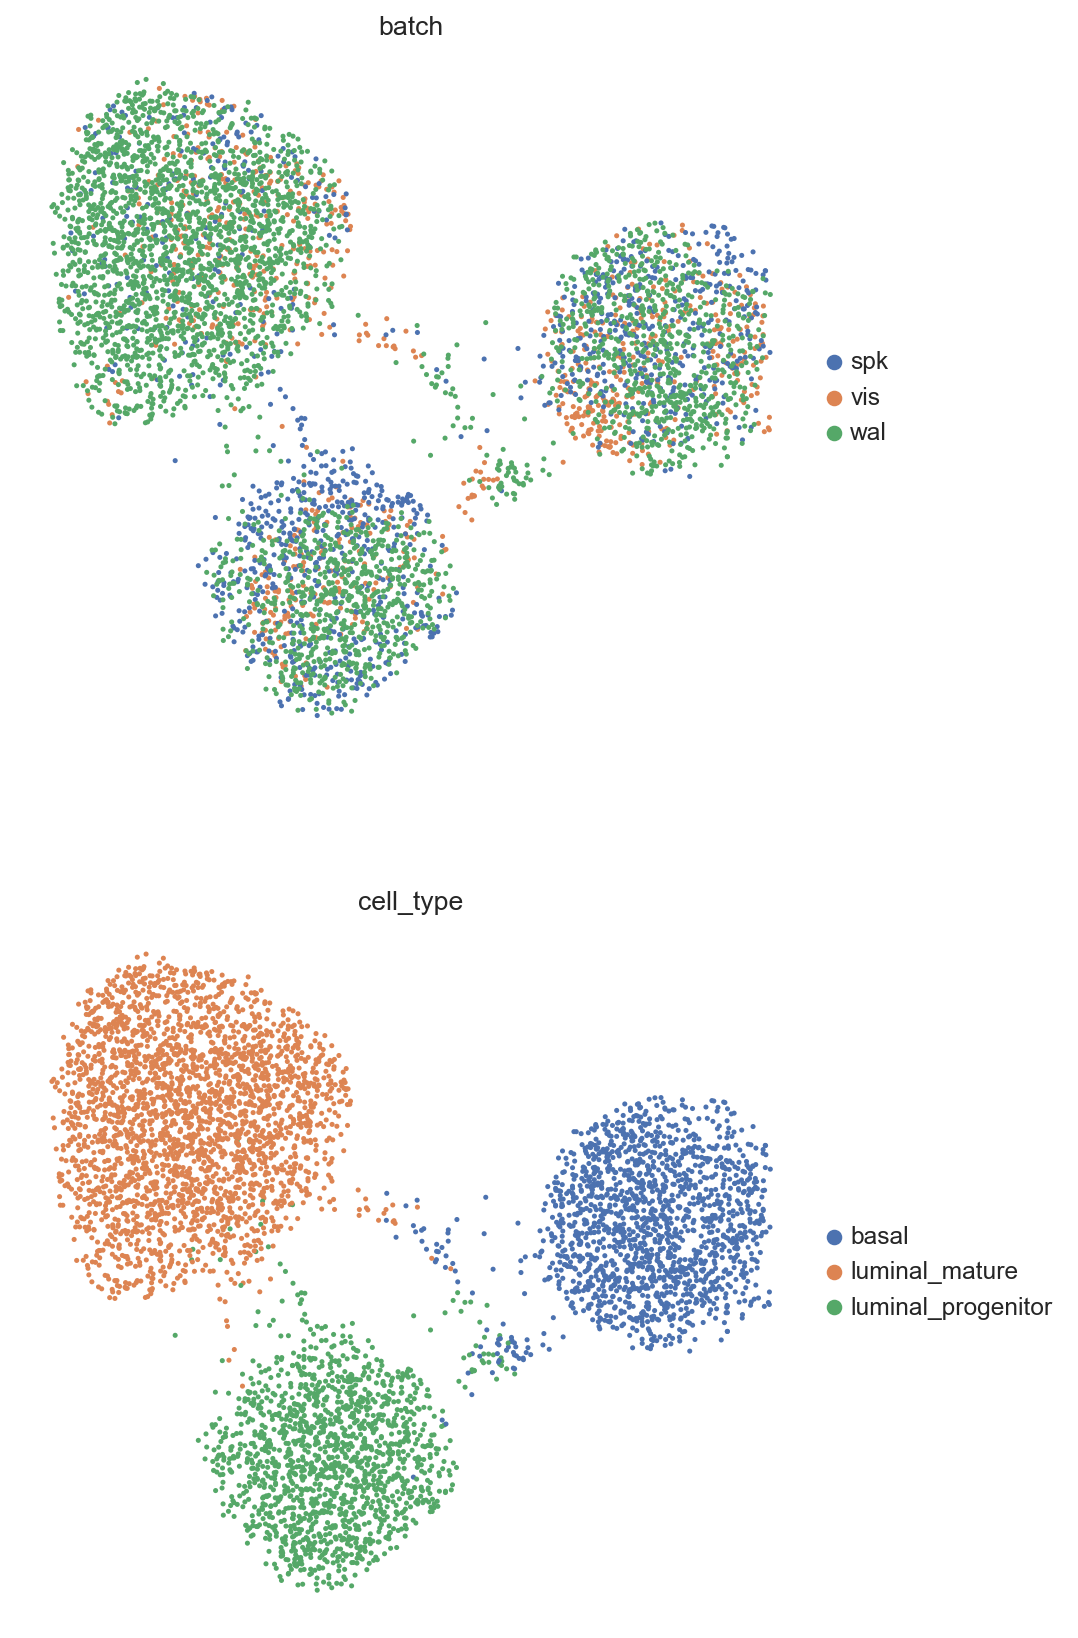

In [11]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# Harmony

In [12]:
# Harmony
sc.tl.pca(adata, n_comps=50)
data_mat = adata.obsm['X_pca']
meta_data = adata.obs

# Specify the variables to use (as in your original code)
vars_use = ['batch']

# Run Harmony
start_time = time.time()
ho = hm.run_harmony(data_mat, meta_data, vars_use)
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Convert the adjusted PCs to a DataFrame
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

# If you want to store the adjusted PCs back into the AnnData object
adata.obsm['X_harmony'] = res.values.T
sc.pp.neighbors(adata, use_rep="X_harmony")
sc.tl.umap(adata, min_dist=0.5)

2024-08-26 09:41:27,526 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-26 09:41:28,841 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-26 09:41:28,855 - harmonypy - INFO - Iteration 1 of 10
2024-08-26 09:41:30,140 - harmonypy - INFO - Iteration 2 of 10
2024-08-26 09:41:31,363 - harmonypy - INFO - Iteration 3 of 10
2024-08-26 09:41:32,623 - harmonypy - INFO - Iteration 4 of 10
2024-08-26 09:41:33,913 - harmonypy - INFO - Iteration 5 of 10
2024-08-26 09:41:34,575 - harmonypy - INFO - Iteration 6 of 10
2024-08-26 09:41:35,062 - harmonypy - INFO - Iteration 7 of 10
2024-08-26 09:41:35,511 - harmonypy - INFO - Iteration 8 of 10
2024-08-26 09:41:35,985 - harmonypy - INFO - Iteration 9 of 10
2024-08-26 09:41:36,448 - harmonypy - INFO - Converged after 9 iterations


Training completed in 8.93 seconds


In [13]:
# Save embeddings
adata.obsm["X_harmony"] = adata.obsm["X_harmony"]

# Collect embeddings
embeddings_dict["X_harmony"] = adata.obsm["X_harmony"]

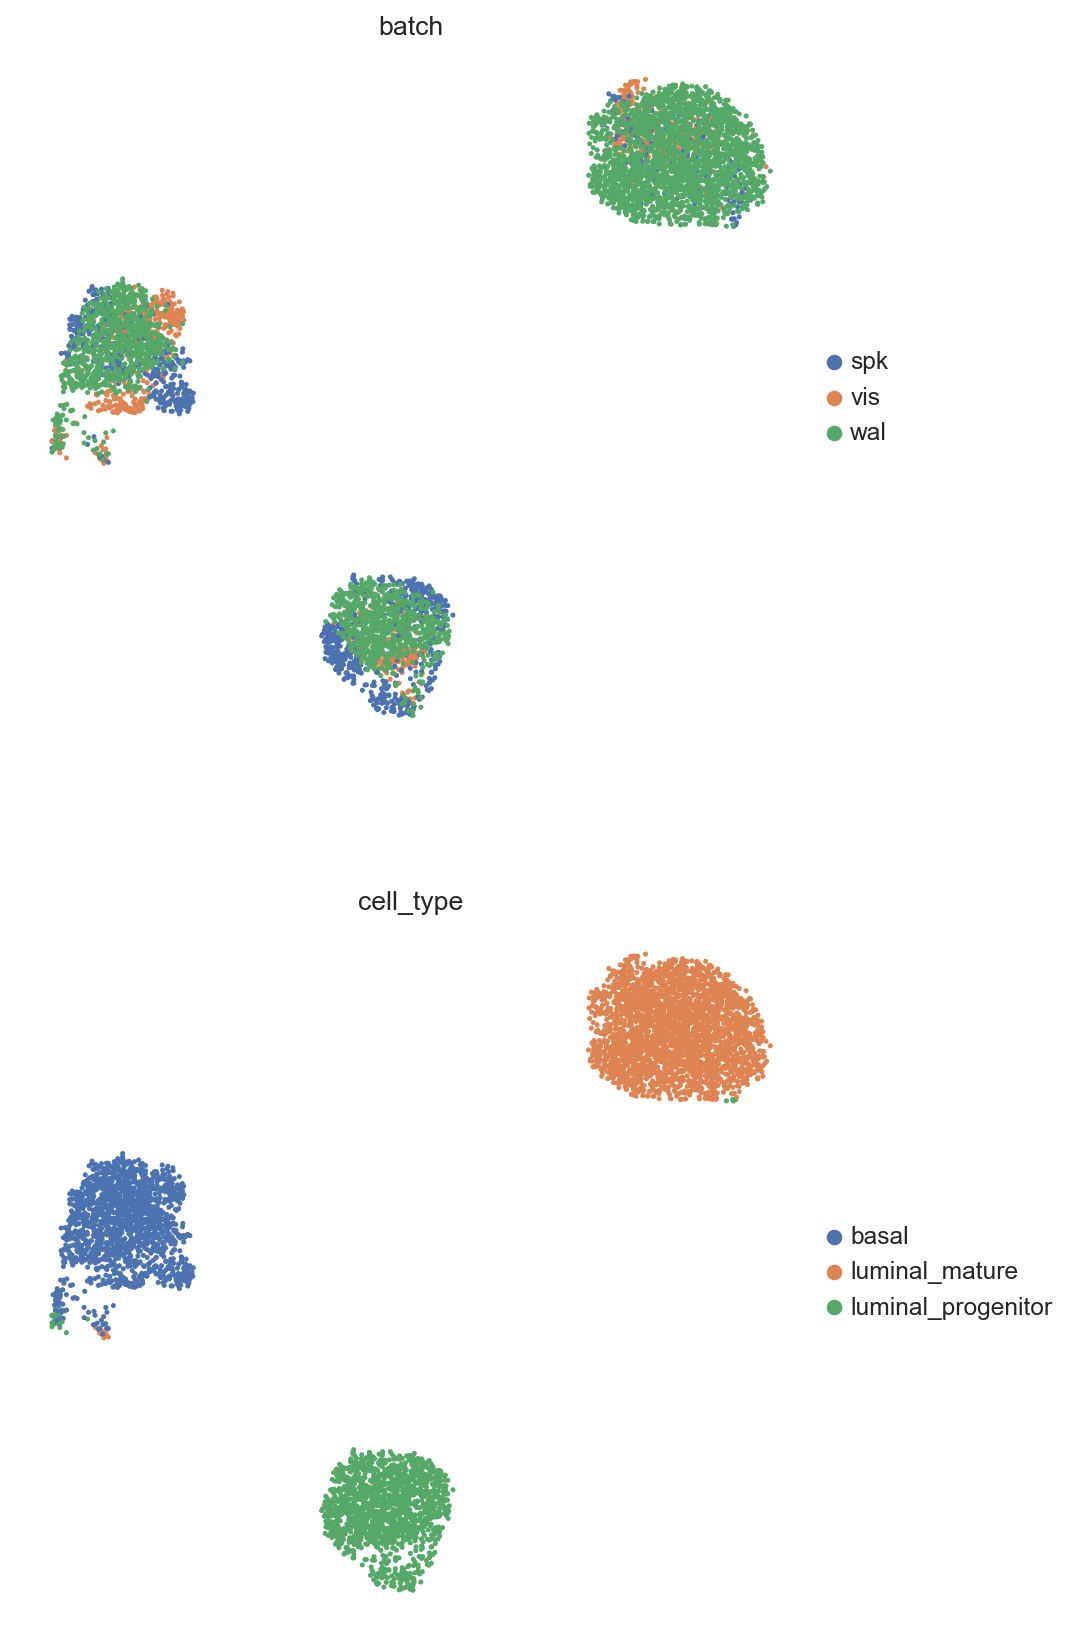

In [14]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# Seurat

In [15]:
pca_embeddings = pd.read_csv('../R_bct/embeddings/bct_seurat_embeddings.csv', index_col=0)
adata.obsm['X_seurat'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_seurat")
sc.tl.umap(adata, min_dist=0.5)

In [16]:
# Collect embeddings
embeddings_dict["X_seurat"] = adata.obsm["X_seurat"]

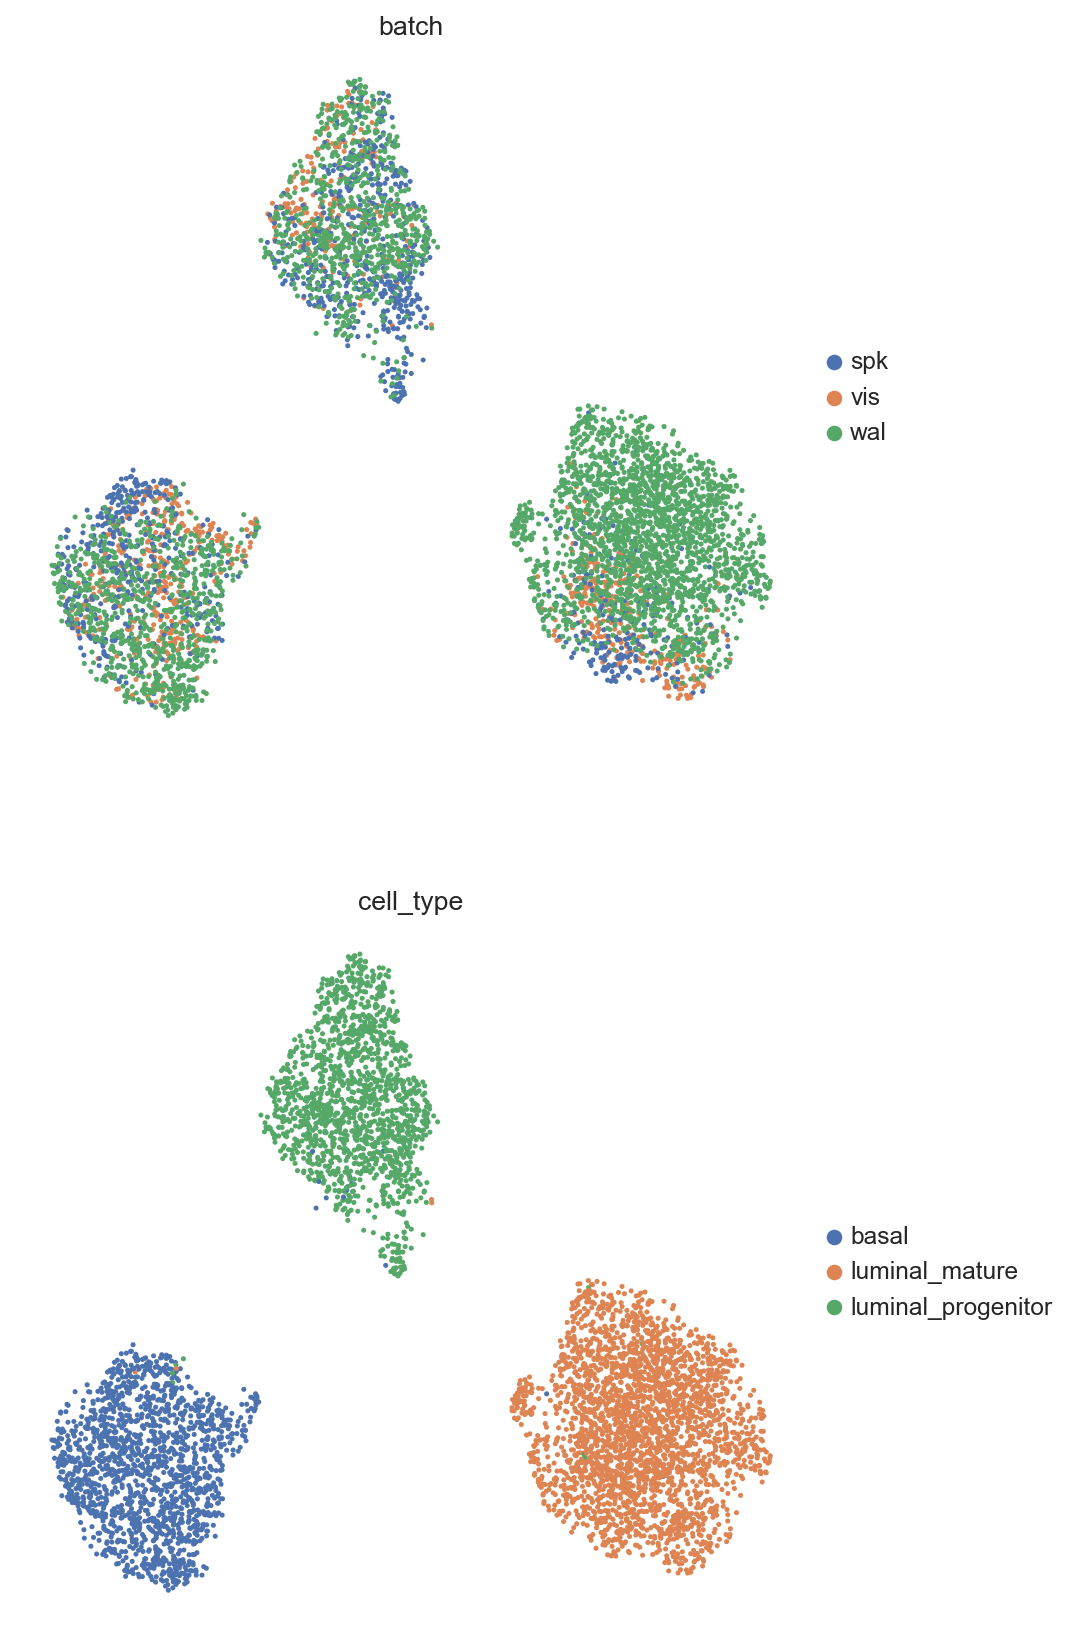

In [17]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [14]:
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/full_annotated_unsupervised_bct.csv")


# Metric Evaluation

## read the embeddings

In [9]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("../embeddings/full_annotated_unsupervised_bct.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scVI", "X_harmony", "X_scCRAFT", "X_seurat"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [30]:
sc.pp.neighbors(adata, use_rep="X_scVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,   batch_key='batch', label_key = 'cell_type', embed = 'X_scVI')

resolution: 0.1, nmi: 0.9386588670317075
resolution: 0.2, nmi: 0.9434934922846719
resolution: 0.3, nmi: 0.9360366173280376
resolution: 0.4, nmi: 0.9273342868749574
resolution: 0.5, nmi: 0.9254729612410629
resolution: 0.6, nmi: 0.9236634088112609
resolution: 0.7, nmi: 0.9252892681076035
resolution: 0.8, nmi: 0.8064845893044016
resolution: 0.9, nmi: 0.8049405666810252
resolution: 1.0, nmi: 0.7576775734460109
resolution: 1.1, nmi: 0.7183993197996553
resolution: 1.2, nmi: 0.6983953202081745
resolution: 1.3, nmi: 0.6791680020778491
resolution: 1.4, nmi: 0.6160141134281746
resolution: 1.5, nmi: 0.579986681567205
resolution: 1.6, nmi: 0.5669125761817562
resolution: 1.7, nmi: 0.5619062288244183
resolution: 1.8, nmi: 0.5129893070908524
resolution: 1.9, nmi: 0.5100481739532823
resolution: 2.0, nmi: 0.5023655822512897
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.9434934922846719
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on

In [31]:
sc.pp.neighbors(adata, use_rep="X_harmony")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True, batch_key='batch', label_key = 'cell_type', embed = 'X_harmony')

resolution: 0.1, nmi: 0.9596248920765578
resolution: 0.2, nmi: 0.9484104159929014
resolution: 0.3, nmi: 0.9484104159929014
resolution: 0.4, nmi: 0.9484104159929014
resolution: 0.5, nmi: 0.948987462413835
resolution: 0.6, nmi: 0.8336305572938727
resolution: 0.7, nmi: 0.7879441225970678
resolution: 0.8, nmi: 0.7209133727836551
resolution: 0.9, nmi: 0.70372460904619
resolution: 1.0, nmi: 0.7029447801497153
resolution: 1.1, nmi: 0.6964551751734402
resolution: 1.2, nmi: 0.6607501840846952
resolution: 1.3, nmi: 0.6361523412759713
resolution: 1.4, nmi: 0.5800578531671166
resolution: 1.5, nmi: 0.5878944499895135
resolution: 1.6, nmi: 0.5471799122655799
resolution: 1.7, nmi: 0.5467373214774288
resolution: 1.8, nmi: 0.5434389420934029
resolution: 1.9, nmi: 0.513080376871742
resolution: 2.0, nmi: 0.5217129515781733
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.9596248920765578
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on re

In [32]:
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True, batch_key='batch', label_key = 'cell_type', embed = 'X_scCRAFT')

resolution: 0.1, nmi: 0.860807902788738
resolution: 0.2, nmi: 0.8617134970931966
resolution: 0.3, nmi: 0.8617134970931966
resolution: 0.4, nmi: 0.792015837060018
resolution: 0.5, nmi: 0.7908372991236637
resolution: 0.6, nmi: 0.760879750922835
resolution: 0.7, nmi: 0.761197113517753
resolution: 0.8, nmi: 0.7607206142004472
resolution: 0.9, nmi: 0.7606138876563228
resolution: 1.0, nmi: 0.7227619476627759
resolution: 1.1, nmi: 0.7226776345475674
resolution: 1.2, nmi: 0.7221819596046619
resolution: 1.3, nmi: 0.7224170411440128
resolution: 1.4, nmi: 0.7211677564402269
resolution: 1.5, nmi: 0.7200915212358758
resolution: 1.6, nmi: 0.6856505295232371
resolution: 1.7, nmi: 0.6898781842120759
resolution: 1.8, nmi: 0.6471148575481904
resolution: 1.9, nmi: 0.6303524929345652
resolution: 2.0, nmi: 0.6278689812608321
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.8617134970931966
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on re

In [33]:
sc.pp.neighbors(adata, use_rep="X_seurat")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df4_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True, batch_key='batch', label_key = 'cell_type', embed = 'X_seurat')

resolution: 0.1, nmi: 0.9698818053104268
resolution: 0.2, nmi: 0.9698818053104268
resolution: 0.3, nmi: 0.9698818053104268
resolution: 0.4, nmi: 0.9290949787452968
resolution: 0.5, nmi: 0.8479497664865179
resolution: 0.6, nmi: 0.7672119996215663
resolution: 0.7, nmi: 0.6712992747269378
resolution: 0.8, nmi: 0.6588899161709241
resolution: 0.9, nmi: 0.6248836505208442
resolution: 1.0, nmi: 0.5828602826562679
resolution: 1.1, nmi: 0.5577144198877637
resolution: 1.2, nmi: 0.5494802414742971
resolution: 1.3, nmi: 0.5425079685924747
resolution: 1.4, nmi: 0.5353777414883584
resolution: 1.5, nmi: 0.5270451305412909
resolution: 1.6, nmi: 0.5113579288969439
resolution: 1.7, nmi: 0.5011153257402592
resolution: 1.8, nmi: 0.4986958155903787
resolution: 1.9, nmi: 0.5034082298724851
resolution: 2.0, nmi: 0.4919141759645183
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.9698818053104268
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors o

In [34]:
# Adding new columns to each dataframe
df1_1['scVI'] = df1_1.iloc[:, 0]
df2_1['Harmony'] = df2_1.iloc[:, 0]
df3_1['scCRAFT'] = df3_1.iloc[:, 0]
df4_1['Seurat'] = df4_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scVI']]
df2_1 = df2_1[['Harmony']]
df3_1 = df3_1[['scCRAFT']]
df4_1 = df4_1[['Seurat']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1, df4_1], axis=1)

merged_df.to_csv("../metrics/bct_metrics_unsupervised.csv", index=False)

In [35]:
merged_df

,scVI,Harmony,scCRAFT,Seurat
NMI_cluster/label,0.947588,0.956983,0.862668,0.969458
ARI_cluster/label,0.973605,0.977680,0.893895,0.986136
ASW_label,0.561746,0.718326,0.690350,0.722325
ASW_label/batch,0.907120,0.956590,0.908472,0.907664
PCR_batch,NaN,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN,NaN
isolated_label_F1,0.987891,0.991525,0.930347,0.994781
isolated_label_silhouette,0.560000,0.712991,0.682611,0.711087
graph_conn,0.999776,1.000000,0.931854,0.999875
kBET,NaN,NaN,NaN,NaN
